## 1.1.1

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import random

# Reproducibility seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [43]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  


SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

In [44]:
def create_k_regular_graph(n, k):
    """
    Create a k-regular graph adjacency matrix where each node is connected
    to its k nearest neighbors in a circular manner.
    """
    rows = []
    cols = []
    
    # For each node i, neighbors are ±1, ±2 ... up to k/2
    half_k = k // 2
    
    for i in range(n):
        for offset in range(1, half_k + 1):
            # right neighbor (i + offset)
            neighbor_r = (i + offset) % n
            rows.append(i)
            cols.append(neighbor_r)
            
            # left neighbor (i - offset)
            neighbor_l = (i - offset) % n
            rows.append(i)
            cols.append(neighbor_l)
            
    data = np.ones(len(rows))
    adj_matrix = sparse.csr_matrix((data, (rows, cols)), shape=(n, n))
    return adj_matrix

In [45]:
def run_simulation(adj_matrix, n_nodes, weeks, beta, rho, initial_infected, initial_infected_choice='random'):
    # at the beginning all nodes are susceptible -> everyone is S = 0
    states = np.zeros(n_nodes, dtype=int)
    
    if initial_infected_choice == 'random':
        initial_infected_indices = np.random.choice(n_nodes, initial_infected, replace=False)
    elif initial_infected_choice == 'cluster':
        start_node = np.random.randint(0, n_nodes)
        initial_infected_indices = [(start_node + i) % n_nodes for i in range(initial_infected)]

    states[initial_infected_indices] = INFECTED
    
    # i = 0 for initial state, i = 1..15 for next weeks
    history_S = np.zeros(weeks + 1)
    history_I = np.zeros(weeks + 1)
    history_R = np.zeros(weeks + 1)
    new_infections_hist = np.zeros(weeks + 1)
    
    # initial state (t=0)
    history_S[0] = np.sum(states == SUSCEPTIBLE)
    history_I[0] = np.sum(states == INFECTED)
    history_R[0] = np.sum(states == RECOVERED)
    new_infections_hist[0] = initial_infected
    
    for t in range(weeks):
        # current infected nodes
        infected_mask = (states == INFECTED)
        
        # number of infected neighbors for each node
        m = adj_matrix.dot(infected_mask.astype(int))
        
        # P(S -> I) = 1 - (1 - beta)^m
        prob_infection = 1 - (1 - beta) ** m
        
        random_vals = np.random.rand(n_nodes)
        
        newly_infected_mask = (states == SUSCEPTIBLE) & (random_vals < prob_infection)
        
        # P(I -> R) = rho 
        random_vals_rec = np.random.rand(n_nodes)
        newly_recovered_mask = (states == INFECTED) & (random_vals_rec < rho)
        
        # states update synchronously given the discrete time nature of the model
        states[newly_infected_mask] = INFECTED
        states[newly_recovered_mask] = RECOVERED
        
        count_S = np.sum(states == SUSCEPTIBLE)
        count_I = np.sum(states == INFECTED)
        count_R = np.sum(states == RECOVERED)
        count_New_I = np.sum(newly_infected_mask)
        
        history_S[t+1] = count_S
        history_I[t+1] = count_I
        history_R[t+1] = count_R
        new_infections_hist[t+1] = count_New_I
        
    return history_S, history_I, history_R, new_infections_hist

### Simulation with random initial infected

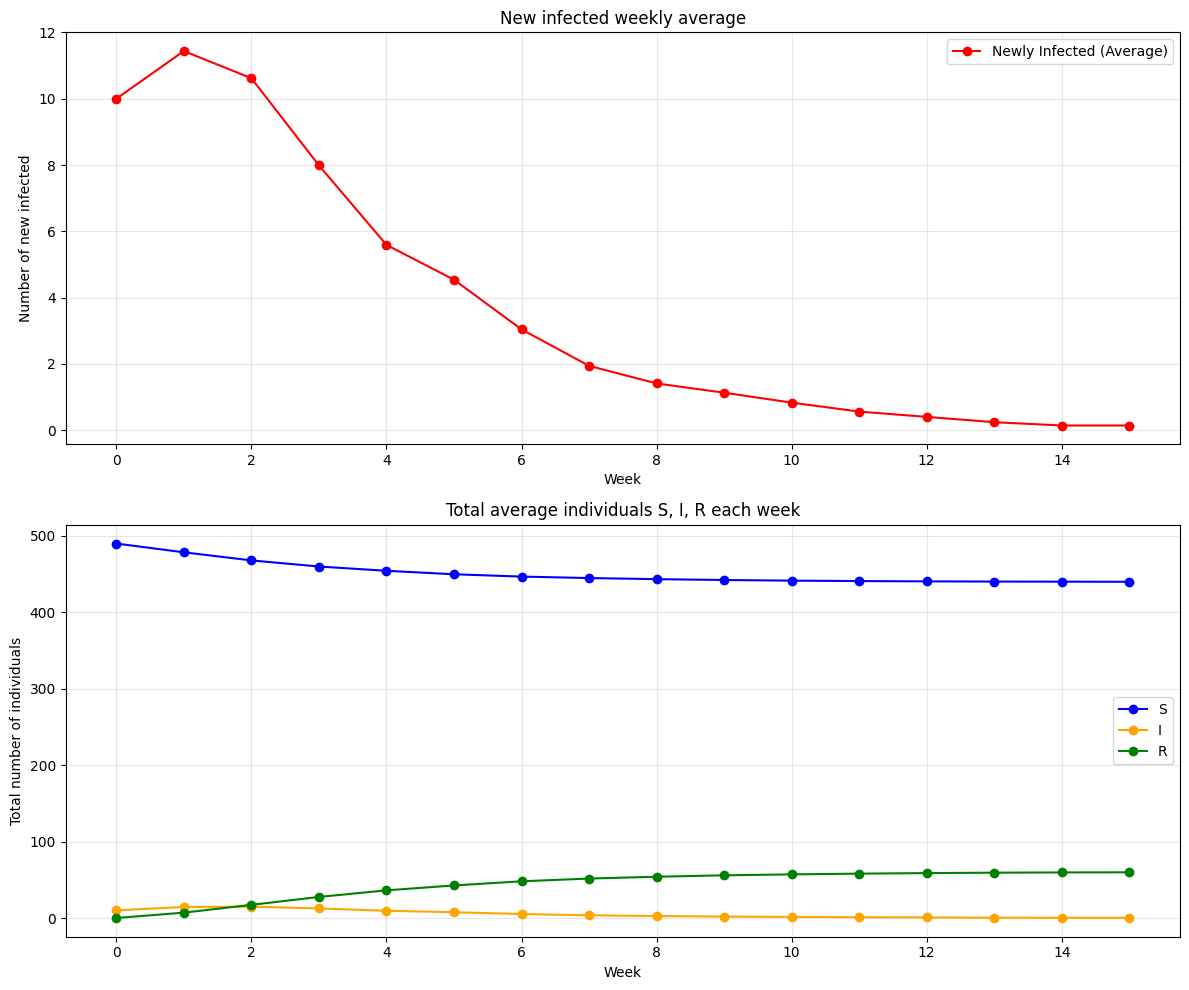

In [46]:
adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)


for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, INITIAL_INFECTED)
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

def plot_epidemic(weeks, avg_S, avg_I, avg_R, avg_new_I):
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    plt.plot(weeks, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Average)')
    plt.title('New infected weekly average')
    plt.xlabel('Week')
    plt.ylabel('Number of new infected')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(weeks, avg_S, marker='o', label='S', color='blue')
    plt.plot(weeks, avg_I, marker='o', label='I', color='orange')
    plt.plot(weeks, avg_R, marker='o', label='R', color='green')
    plt.title('Total average individuals S, I, R each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_epidemic(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

even trying different values of $\beta$ and $\rho$

- with $\beta \cdot k < \rho$: no peak
- with $\beta \cdot k \ge \rho$: peak but then the topology of the net still avoids the epidemic infecting all the population

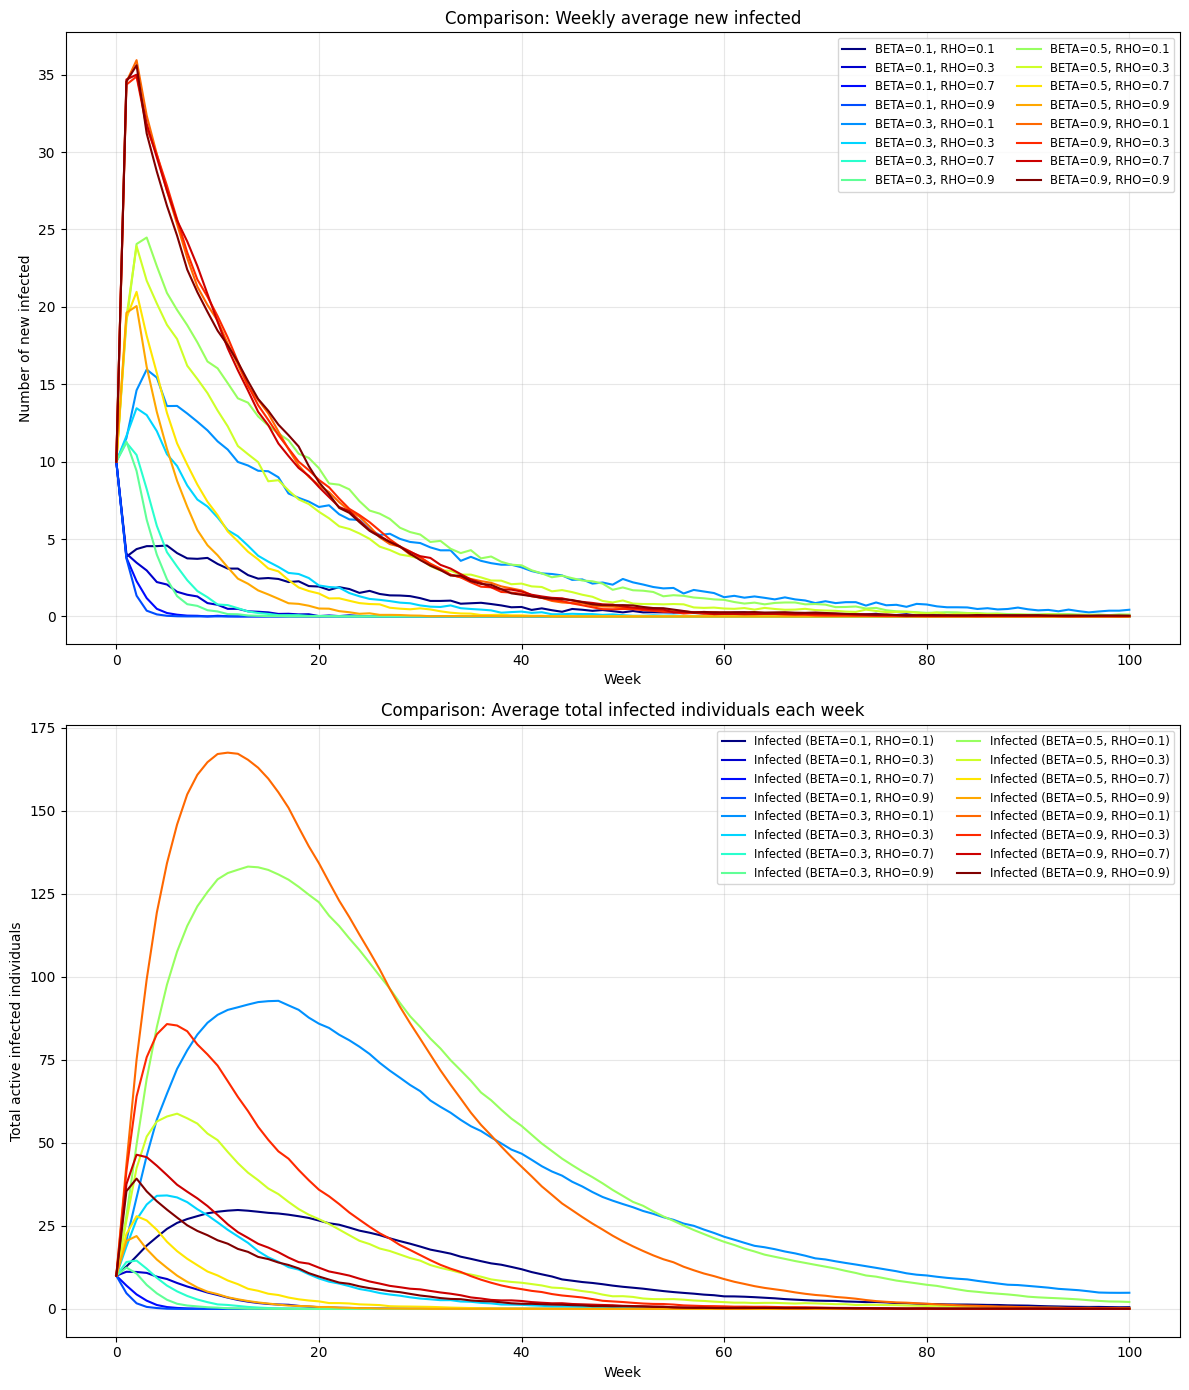

In [47]:
BETA = [0.1, 0.3, 0.5, 0.9]
RHO = [0.1, 0.3, 0.7, 0.9]
WEEKS = 100
weeks_range = np.arange(WEEKS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

colors = plt.cm.jet(np.linspace(0, 1, len(BETA) * len(RHO))) 
c_idx = 0

for beta in BETA:
    for rho in RHO:
        
        total_S = np.zeros(WEEKS + 1)
        total_I = np.zeros(WEEKS + 1)
        total_R = np.zeros(WEEKS + 1)
        total_new_I = np.zeros(WEEKS + 1)

        for sim in range(N_SIMULATIONS):
            s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, beta, rho, INITIAL_INFECTED)
            total_S += s
            total_I += i
            total_R += r
            total_new_I += new_i

        avg_S = total_S / N_SIMULATIONS
        avg_I = total_I / N_SIMULATIONS
        avg_R = total_R / N_SIMULATIONS
        avg_new_I = total_new_I / N_SIMULATIONS

        label_sim = f'BETA={beta}, RHO={rho}'
        
        ax1.plot(weeks_range, avg_new_I, 
                 linestyle='-', 
                 label=label_sim, 
                 color=colors[c_idx])
        
        # just plot avg_I for readability
        ax2.plot(weeks_range, avg_I, 
                 linestyle='-', 
                 label=f'Infected ({label_sim})',
                 color=colors[c_idx])
        
        c_idx += 1

ax1.set_title('Comparison: Weekly average new infected')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of new infected')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small', ncol=2)

ax2.set_title('Comparison: Average total infected individuals each week')
ax2.set_xlabel('Week')
ax2.set_ylabel('Total active infected individuals')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

### Simulation with initial infected taken from a cluster

Choosing 10 neighbor nodes as initial infected, the epidemic dies out even faster because the initial infected shares the same suscepitble neighbors saturating the infection locally.

In a cluster, many of the links of infected nodes point to other already infected nodes within the group. These links are "wasted" because they cannot transmit the infection to new susceptible nodes. In the random configuration, however, almost all the links of the 10 infected nodes point to susceptible nodes, maximizing the probability of immediate expansion.

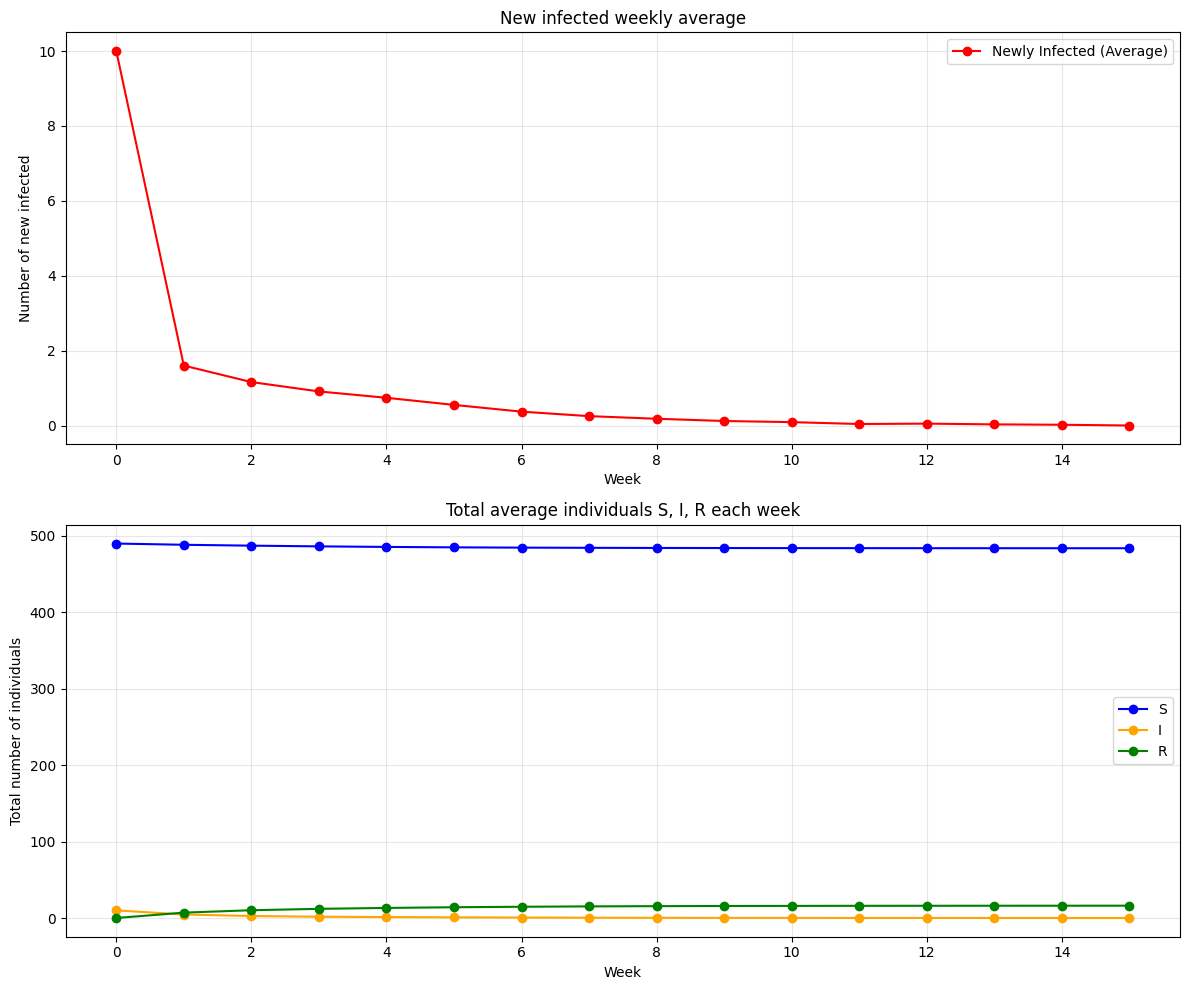

In [48]:
N_NODES = 500          
K_NEIGHBORS = 4        
BETA = 0.3             
RHO = 0.7              
WEEKS = 15             
N_SIMULATIONS = 100    
INITIAL_INFECTED = 10  

adj_matrix = create_k_regular_graph(N_NODES, K_NEIGHBORS)

total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)


for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, INITIAL_INFECTED, initial_infected_choice='cluster')
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)
plot_epidemic(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

### Simulation with different values of $k$ and initial infected

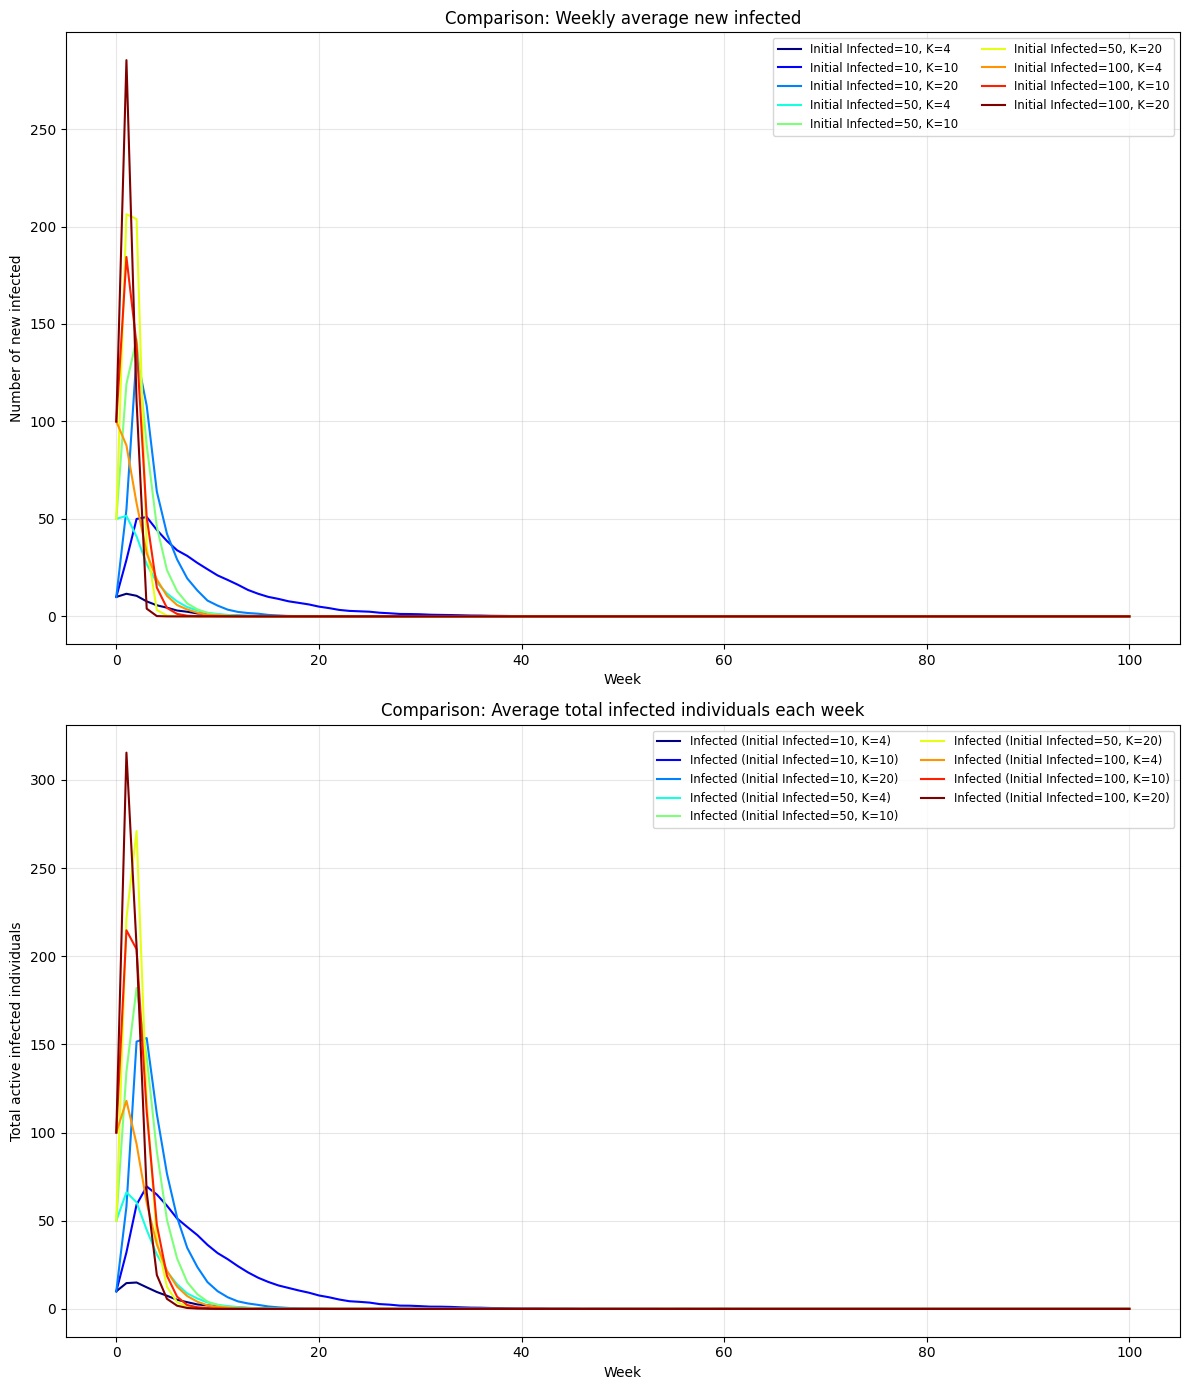

In [49]:
BETA = 0.3
RHO = 0.7
INITIAL_INFECTED = [10, 50, 100]
K_NEIGHBORS = [4, 10, 20]
WEEKS = 100
weeks_range = np.arange(WEEKS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

colors = plt.cm.jet(np.linspace(0, 1, len(INITIAL_INFECTED) * len(K_NEIGHBORS))) 
c_idx = 0

for initial_infected in INITIAL_INFECTED:
    for k in K_NEIGHBORS:
        adj_matrix = create_k_regular_graph(N_NODES, k)
        
        total_S = np.zeros(WEEKS + 1)
        total_I = np.zeros(WEEKS + 1)
        total_R = np.zeros(WEEKS + 1)
        total_new_I = np.zeros(WEEKS + 1)

        for sim in range(N_SIMULATIONS):
            s, i, r, new_i = run_simulation(adj_matrix, N_NODES, WEEKS, BETA, RHO, initial_infected)
            total_S += s
            total_I += i
            total_R += r
            total_new_I += new_i

        avg_S = total_S / N_SIMULATIONS
        avg_I = total_I / N_SIMULATIONS
        avg_R = total_R / N_SIMULATIONS
        avg_new_I = total_new_I / N_SIMULATIONS

        label_sim = f'Initial Infected={initial_infected}, K={k}'
        
        ax1.plot(weeks_range, avg_new_I, 
                 linestyle='-', 
                 label=label_sim, 
                 color=colors[c_idx])
        
        # just plot avg_I for readability
        ax2.plot(weeks_range, avg_I, 
                 linestyle='-', 
                 label=f'Infected ({label_sim})',
                 color=colors[c_idx])
        
        c_idx += 1

ax1.set_title('Comparison: Weekly average new infected')
ax1.set_xlabel('Week')
ax1.set_ylabel('Number of new infected')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', fontsize='small', ncol=2)

ax2.set_title('Comparison: Average total infected individuals each week')
ax2.set_xlabel('Week')
ax2.set_ylabel('Total active infected individuals')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize='small', ncol=2)

plt.tight_layout()
plt.show()

## 1.1.2

In [50]:
def generate_PA_graph_target_k(n_total, k):
    """
    Generates a Preferential Attachment graph with n_total nodes 
    and a target average degree of k.
    """
    
    # INITIALIZATION (Time t=1)
    # Start with a complete graph (clique) of k+1 nodes
    # This ensures the initial average degree is exactly k.
    m0 = k + 1
    G = nx.complete_graph(m0)
    
    # Parameters for the alternating mechanism
    is_k_odd = (k % 2 != 0)
    c_floor = int(np.floor(k / 2))
    c_ceil = int(np.ceil(k / 2))
    
    # GROWTH (Time t >= 2)
    # We add nodes one by one from index m0 up to n_total - 1
    for new_node in range(m0, n_total):
        
        # Determine c (number of edges to add)
        if is_k_odd:
            # Alternate between floor and ceil
            # We use the node index to decide (even or odd step)
            if new_node % 2 == 0:
                c = c_floor
            else:
                c = c_ceil
        else:
            # If k is even, c is always k/2
            c = int(k / 2)
            
        # Get the list of existing nodes
        existing_nodes = np.array(G.nodes())
        
        # Get degrees of all existing nodes (w_i(t-1))
        # Note: G.degree() returns (node, degree) tuples, we just need the degrees
        degrees = np.array([G.degree(n) for n in existing_nodes])
        
        # Calculate the sum of degrees (Denominator of the formula)
        degree_sum = degrees.sum()
        
        # Calculate Probabilities
        # P(i) = w_i / sum(w)
        probabilities = degrees / degree_sum
        
        # Select 'c' targets based on these probabilities
        # replace=False ensures we do not add multiple links to the same node
        targets = np.random.choice(existing_nodes, size=c, replace=False, p=probabilities)
        
        # Add the new node and the edges
        G.add_node(new_node)
        for target in targets:
            G.add_edge(new_node, target)
            
    return G

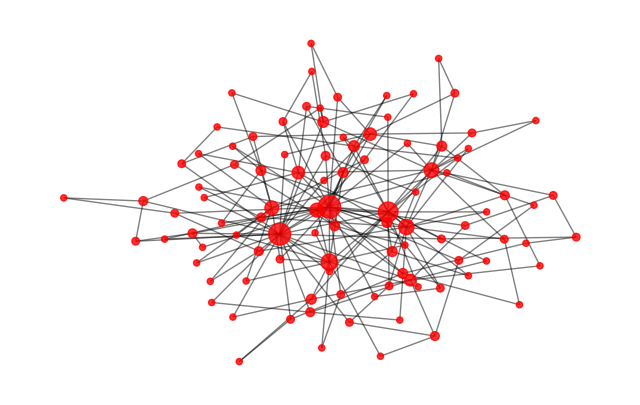

In [51]:
# Test out graph generation and visualize
G = generate_PA_graph_target_k(100, 4)

pos = nx.spring_layout(G, k=0.15, iterations=20, seed=42) 

d = dict(G.degree)
node_sizes = [v * 10 for v in d.values()] # Scale based on degree for visualization

plt.figure(figsize=(8, 5))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='red', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='black')

plt.axis('off')
plt.show()

Target Average Degree: 8
Actual Average Degree: 8.0000


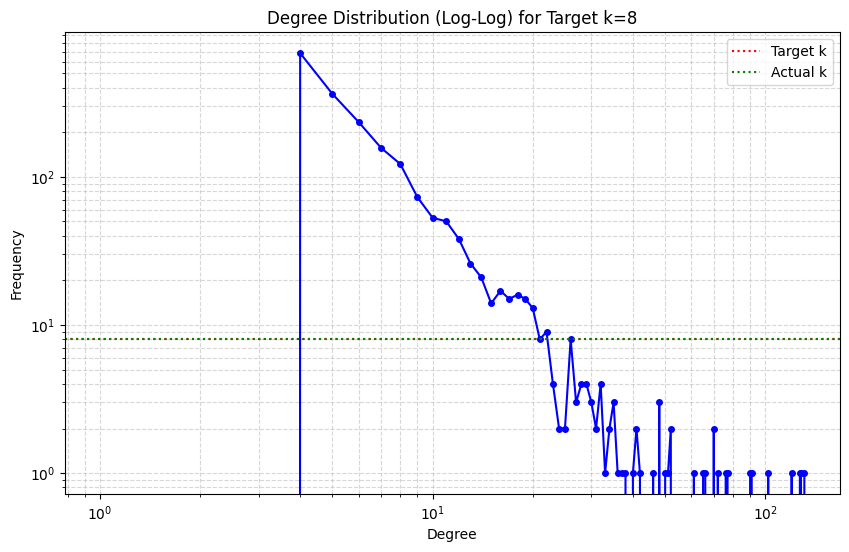

In [52]:
# Parameters
N = 2000     # Final number of nodes
K_TARGET = 8 # Target average degree (even number for default case)

# Generate Graph
G_pa = generate_PA_graph_target_k(N, K_TARGET)

# Compute Actual Average Degree
degrees = [d for n, d in G_pa.degree()]
k_actual = np.mean(degrees)

print(f"Target Average Degree: {K_TARGET}")
print(f"Actual Average Degree: {k_actual:.4f}")

plt.figure(figsize=(10, 6))

# Plot Degree Distribution
degree_freq = nx.degree_histogram(G_pa)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq, 'bo-', markersize=4)
plt.axhline(y=K_TARGET, color='red', linestyle=':', label='Target k')
plt.axhline(y=k_actual, color='green', linestyle=':', label='Actual k')
plt.title(f"Degree Distribution (Log-Log) for Target k={K_TARGET}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

Target Average Degree: 5
Actual Average Degree: 5.0000


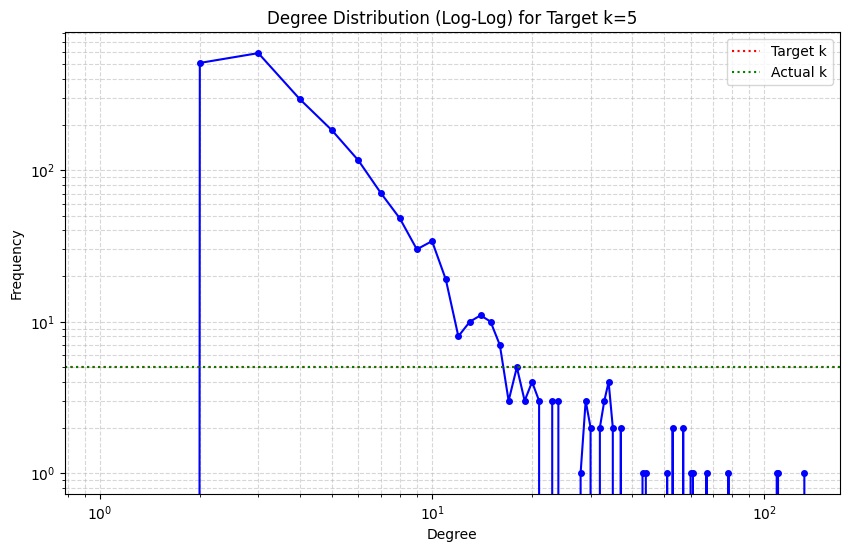

In [53]:
# Parameters
N = 2000     # Final number of nodes
K_TARGET = 5 # Target average degree (Odd number to test the tricky case)

# Generate Graph
G_pa = generate_PA_graph_target_k(N, K_TARGET)

# Compute Actual Average Degree
degrees = [d for n, d in G_pa.degree()]
k_actual = np.mean(degrees)

print(f"Target Average Degree: {K_TARGET}")
print(f"Actual Average Degree: {k_actual:.4f}")

plt.figure(figsize=(10, 6))

# Plot Degree Distribution
degree_freq = nx.degree_histogram(G_pa)
degrees = range(len(degree_freq))
plt.loglog(degrees, degree_freq, 'bo-', markersize=4)
plt.axhline(y=K_TARGET, color='red', linestyle=':', label='Target k')
plt.axhline(y=k_actual, color='green', linestyle=':', label='Actual k')
plt.title(f"Degree Distribution (Log-Log) for Target k={K_TARGET}")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

## 1.2

Generating PA graph with N=500 and K=6...
Running simulations...


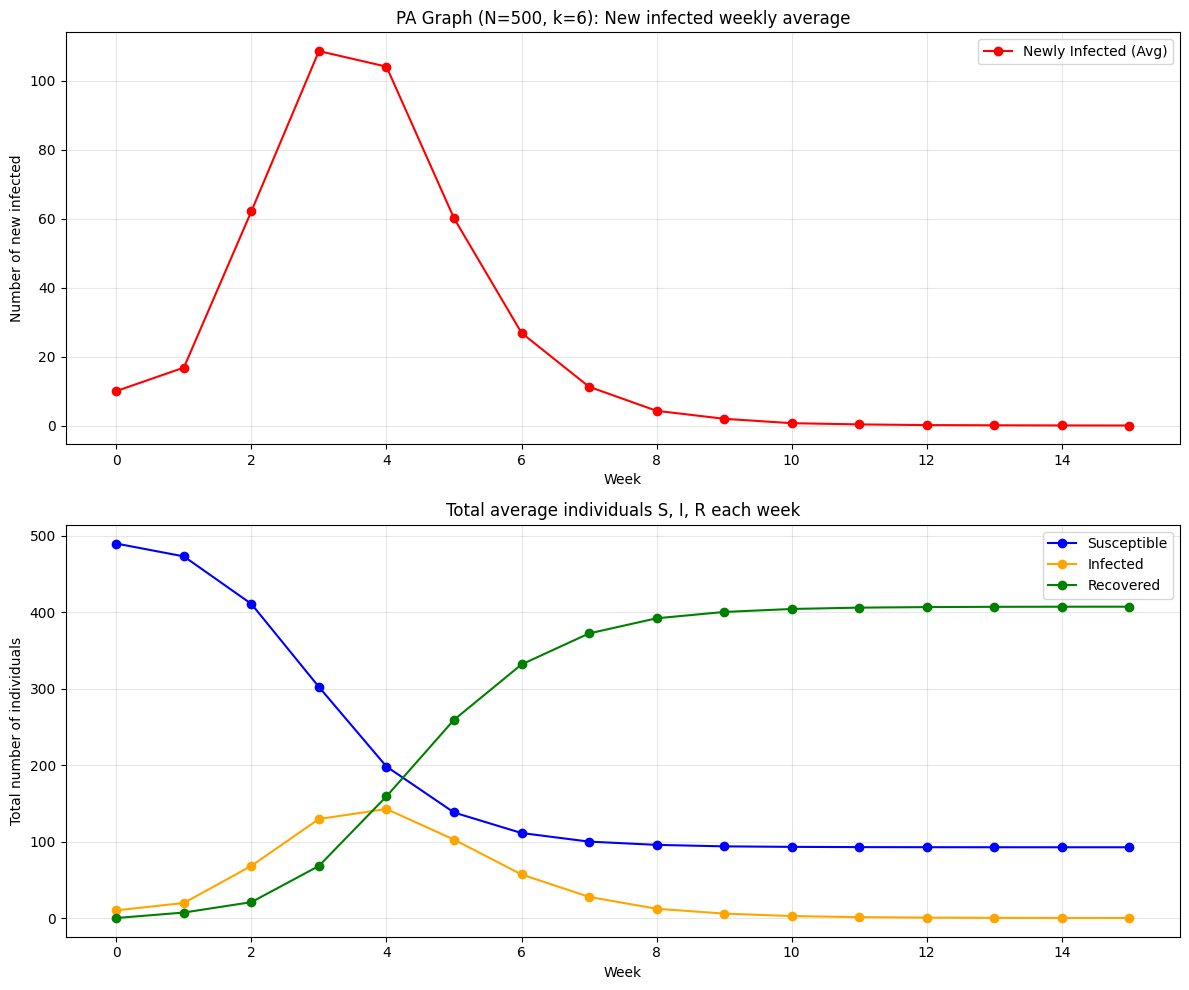

In [54]:
N_NODES =  500          # Graph size
K_TARGET = 6            # Target average degree
BETA = 0.3              # Infection rate
RHO = 0.7               # Recovery rate
WEEKS = 15              # Duration of simulation
N_SIMULATIONS = 100     # Number of runs to average
INITIAL_INFECTED = 10   # Number of initially infected nodes

print(f"Generating PA graph with N={N_NODES} and K={K_TARGET}...")
G_pa = generate_PA_graph_target_k(N_NODES, K_TARGET)
adj_matrix = nx.to_scipy_sparse_array(G_pa, format='csr')

print("Running simulations...")
total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)

for sim in range(N_SIMULATIONS):
    s, i, r, new_i = run_simulation(
        adj_matrix, 
        N_NODES, 
        WEEKS, 
        BETA, 
        RHO, 
        INITIAL_INFECTED, 
        initial_infected_choice='random'
    )
    total_S += s
    total_I += i
    total_R += r
    total_new_I += new_i

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

def plot_epidemic_results(weeks, avg_S, avg_I, avg_R, avg_new_I):
    plt.figure(figsize=(12, 10))

    # Plot New Infections
    plt.subplot(2, 1, 1)
    plt.plot(weeks, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Avg)')
    plt.title(f'PA Graph (N={N_NODES}, k={K_TARGET}): New infected weekly average')
    plt.xlabel('Week')
    plt.ylabel('Number of new infected')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot SIR States
    plt.subplot(2, 1, 2)
    plt.plot(weeks, avg_S, marker='o', label='Susceptible', color='blue')
    plt.plot(weeks, avg_I, marker='o', label='Infected', color='orange')
    plt.plot(weeks, avg_R, marker='o', label='Recovered', color='green')
    plt.title('Total average individuals S, I, R each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_epidemic_results(weeks_range, avg_S, avg_I, avg_R, avg_new_I)

## 1.3

In [55]:
N_NODES =  500          # Graph size
K_TARGET = 6            # Target average degree
BETA = 0.3              # Infection rate
RHO = 0.7               # Recovery rate
WEEKS = 15              # Duration of simulation
N_SIMULATIONS = 100     # Number of runs to average
INITIAL_INFECTED = 10   # Number of initially infected nodes

VACCINATED = 3          # New state
VACCINATION_SCHEDULE_PCT = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]   # Cumulative percentage of population vaccinated each week

In [56]:
def run_simulation_with_vaccination(adj_matrix, n_nodes, weeks, beta, rho, initial_infected, vacc_schedule_pct, initial_infected_choice='random'):
    # at the beginning all nodes are susceptible -> everyone is S = 0
    states = np.zeros(n_nodes, dtype=int)
    
    if initial_infected_choice == 'random':
        initial_infected_indices = np.random.choice(n_nodes, initial_infected, replace=False)
    elif initial_infected_choice == 'cluster':
        start_node = np.random.randint(0, n_nodes)
        initial_infected_indices = [(start_node + i) % n_nodes for i in range(initial_infected)]

    states[initial_infected_indices] = INFECTED
    
    # i = 0 for initial state, i = 1..15 for next weeks
    history_S = np.zeros(weeks + 1)
    history_I = np.zeros(weeks + 1)
    history_R = np.zeros(weeks + 1)
    history_V = np.zeros(weeks + 1)
    
    new_infections_hist = np.zeros(weeks + 1)
    new_vaccinations_hist = np.zeros(weeks + 1)
    
    # initial state (t=0)
    history_S[0] = np.sum(states == SUSCEPTIBLE)
    history_I[0] = np.sum(states == INFECTED)
    history_R[0] = np.sum(states == RECOVERED)
    history_V[0] = np.sum(states == VACCINATED)
    new_infections_hist[0] = initial_infected
    new_vaccinations_hist[0] = 0    # no vaccination happens in the initial state
    

    for t in range(weeks):
        # Compute  percentual of people that could be vaccinated during this week
        target_pct = vacc_schedule_pct[t]
        
        prev_pct = vacc_schedule_pct[t-1] if t > 0 else 0
        
        delta_pct = target_pct - prev_pct
        
        num_newly_vaccinated = 0
        
        if delta_pct > 0:
            num_to_vaccinate = int((delta_pct / 100.0) * n_nodes)
            
            # candidates who are not already vaccinated
            candidate_mask = (states != VACCINATED)
            candidate_indices = np.where(candidate_mask)[0]
            
            num_actual = min(num_to_vaccinate, len(candidate_indices))
            
            if num_actual > 0:
                chosen_indices = np.random.choice(candidate_indices, num_actual, replace=False)
                
                # Apply the Vaccination
                states[chosen_indices] = VACCINATED
                num_newly_vaccinated = num_actual

 
        # currently infected nodes
        infected_mask = (states == INFECTED)
        
        # number of infected neighbors for each node
        m = adj_matrix.dot(infected_mask.astype(int))
        
        # P(S -> I) = 1 - (1 - beta)^m
        prob_infection = 1 - (1 - beta) ** m
        
        random_vals = np.random.rand(n_nodes)
        
        newly_infected_mask = (states == SUSCEPTIBLE) & (random_vals < prob_infection)
        

        # P(I -> R) = rho 
        random_vals_rec = np.random.rand(n_nodes)
        newly_recovered_mask = (states == INFECTED) & (random_vals_rec < rho)
        
        # states update synchronously given the discrete time nature of the model
        states[newly_infected_mask] = INFECTED
        states[newly_recovered_mask] = RECOVERED
        
        history_S[t+1] = np.sum(states == SUSCEPTIBLE)
        history_I[t+1] = np.sum(states == INFECTED)
        history_R[t+1] = np.sum(states == RECOVERED)
        history_V[t+1] = np.sum(states == VACCINATED)
        
        new_infections_hist[t+1] = np.sum(newly_infected_mask)
        new_vaccinations_hist[t+1] = num_newly_vaccinated
        
    return history_S, history_I, history_R, history_V, new_infections_hist, new_vaccinations_hist

In [57]:
print(f"Generating PA graph with N={N_NODES} and K={K_TARGET}...")
G_pa_vacc = generate_PA_graph_target_k(N_NODES, K_TARGET)
adj_matrix_vacc = nx.to_scipy_sparse_array(G_pa_vacc, format='csr')

print("Running simulations with vaccination...")
total_S = np.zeros(WEEKS + 1)
total_I = np.zeros(WEEKS + 1)
total_R = np.zeros(WEEKS + 1)
total_V = np.zeros(WEEKS + 1)
total_new_I = np.zeros(WEEKS + 1)
total_new_V = np.zeros(WEEKS + 1)

for sim in range(N_SIMULATIONS):
    s, i, r, v, new_i, new_v = run_simulation_with_vaccination(
        adj_matrix_vacc, 
        N_NODES, 
        WEEKS, 
        BETA, 
        RHO, 
        INITIAL_INFECTED,
        VACCINATION_SCHEDULE_PCT,
        initial_infected_choice='random'
    )
    total_S += s
    total_I += i
    total_R += r
    total_V += v
    total_new_I += new_i
    total_new_V += new_v

avg_S = total_S / N_SIMULATIONS
avg_I = total_I / N_SIMULATIONS
avg_R = total_R / N_SIMULATIONS
avg_V = total_V / N_SIMULATIONS
avg_new_I = total_new_I / N_SIMULATIONS
avg_new_V = total_new_V / N_SIMULATIONS

weeks_range = np.arange(WEEKS + 1)

Generating PA graph with N=500 and K=6...
Running simulations with vaccination...


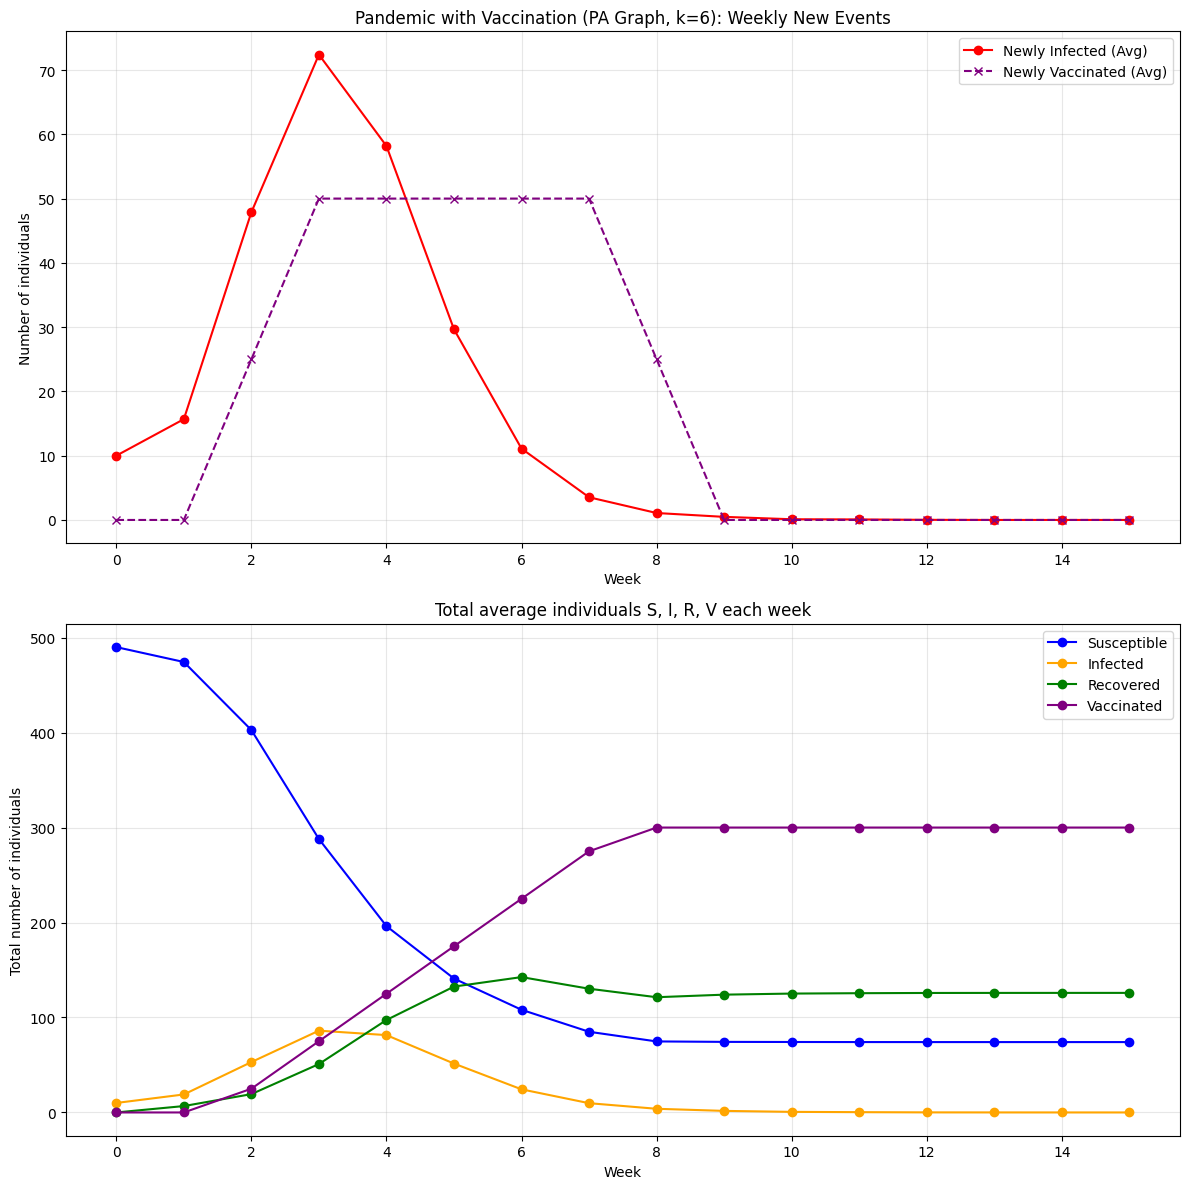

In [58]:
def plot_epidemic_with_vaccination_results(weeks_range, avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V):
    plt.figure(figsize=(12, 12))

    # Plot New Infections and New Vaccinations
    plt.subplot(2, 1, 1)
    plt.plot(weeks_range, avg_new_I, marker='o', color='red', linestyle='-', label='Newly Infected (Avg)')
    plt.plot(weeks_range, avg_new_V, marker='x', color='purple', linestyle='--', label='Newly Vaccinated (Avg)')
    plt.title(f'Pandemic with Vaccination (PA Graph, k={K_TARGET}): Weekly New Events')
    plt.xlabel('Week')
    plt.ylabel('Number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot SIRV States
    plt.subplot(2, 1, 2)
    plt.plot(weeks_range, avg_S, marker='o', label='Susceptible', color='blue')
    plt.plot(weeks_range, avg_I, marker='o', label='Infected', color='orange')
    plt.plot(weeks_range, avg_R, marker='o', label='Recovered', color='green')
    plt.plot(weeks_range, avg_V, marker='o', label='Vaccinated', color='purple')
    plt.title('Total average individuals S, I, R, V each week')
    plt.xlabel('Week')
    plt.ylabel('Total number of individuals')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_epidemic_with_vaccination_results(weeks_range, avg_S, avg_I, avg_R, avg_V, avg_new_I, avg_new_V)

In [59]:
# Dati del testo
VACC = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]   # 15 settimane
I0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0], dtype=float)  # len=16

NODES = 934
WEEKS = 15
N = 10 

initial_infected = int(I0[0])

assert len(VACC) == WEEKS
assert len(I0) == WEEKS + 1

In [60]:
def simulate_avg_I_and_states(k, beta, rho):
    # 1a) grafo PA (Sez 1.1.2)
    G = generate_PA_graph_target_k(NODES, int(k))
    adj = nx.to_scipy_sparse_array(G, format='csr')

    # 1b) simula 15 settimane (Sez 1.3) N=10 volte, media
    total_new_I = np.zeros(WEEKS + 1)
    total_S = np.zeros(WEEKS + 1)
    total_I = np.zeros(WEEKS+ 1)
    total_R = np.zeros(WEEKS + 1)
    total_V = np.zeros(WEEKS + 1)

    for _ in range(N):
        S, I, R, V, new_I, new_V = run_simulation_with_vaccination(
            adj, NODES, WEEKS, beta, rho, initial_infected, VACC,
            initial_infected_choice='random'
        )
        total_S += S
        total_I += I
        total_R += R
        total_V += V
        total_new_I += new_I

    avg_S = total_S / N
    avg_I = total_I / N
    avg_R = total_R / N
    avg_V = total_V / N
    avg_new_I = total_new_I / N  

    # 1c) RMSE del testo: t=1..15
    # Nel tuo codice new_I[0] è l'iniziale, quindi confronto su [1:]
    rmse = np.sqrt((1/15) * np.sum((avg_new_I[1:] - I0[1:])**2))

    return rmse, avg_new_I, avg_S, avg_I, avg_R, avg_V


In [61]:
def fit_h1n1(k0=10, beta0=0.3, rho0=0.6, dk=1, db=0.1, dr=0.1):
    # minimo globale (essenziale)
    global_best = None  # (rmse, k, beta, rho, avg_new_I, avg_S, avg_I, avg_R, avg_V)

    while True:
        # 1) esplora il vicinato
        k_space = [k0 - dk, k0, k0 + dk]
        b_space = [beta0 - db, beta0, beta0 + db]
        r_space = [rho0 - dr,  rho0,  rho0 + dr]

        best_local = None  # (rmse, k, beta, rho, ...)

        for k in k_space:
            if k < 2:
                continue
            for beta in b_space:
                if beta < 0 or beta > 1: #beta is a probability, so a beta greater than one or lower than 0 is not admitted
                    continue
                for rho in r_space:
                    if rho < 0 or rho > 1: # same for beta
                        continue

                    rmse, avg_new_I, avg_S, avg_I, avg_R, avg_V = simulate_avg_I_and_states(k, beta, rho)
                    cand = (rmse, int(k), float(beta), float(rho), avg_new_I, avg_S, avg_I, avg_R, avg_V)

                    if (best_local is None) or (cand[0] < best_local[0]):
                        best_local = cand

                    if (global_best is None) or (cand[0] < global_best[0]):
                        global_best = cand

        # 2) update e stop se non cambia
        rmse_best, k_best, beta_best, rho_best = best_local[0], best_local[1], best_local[2], best_local[3]
        print(f"best local RMSE={rmse_best:.4f} at (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f})")

        if (k_best == k0) and (beta_best == beta0) and (rho_best == rho0):
            break

        k0, beta0, rho0 = k_best, beta_best, rho_best

    return global_best


In [62]:
best = fit_h1n1(k0=10, beta0=0.3, rho0=0.6, dk=1, db=0.1, dr=0.1)

rmse_best, k_best, beta_best, rho_best, avg_new_I, avg_S, avg_I, avg_R, avg_V = best

print("\n=== BEST PARAMETERS (global minimum found) ===")
print(f"k    = {k_best}")
print(f"beta = {beta_best}")
print(f"rho  = {rho_best}")
print(f"RMSE = {rmse_best:.4f}")


best local RMSE=7.1632 at (k=10, beta=0.200, rho=0.600)
best local RMSE=8.7788 at (k=10, beta=0.100, rho=0.700)
best local RMSE=5.1873 at (k=9, beta=0.200, rho=0.700)
best local RMSE=3.9296 at (k=10, beta=0.200, rho=0.800)
best local RMSE=3.6332 at (k=9, beta=0.200, rho=0.800)
best local RMSE=3.9558 at (k=10, beta=0.200, rho=0.700)
best local RMSE=9.1265 at (k=11, beta=0.100, rho=0.600)
best local RMSE=5.8408 at (k=10, beta=0.200, rho=0.700)
best local RMSE=6.0209 at (k=9, beta=0.200, rho=0.800)
best local RMSE=5.1312 at (k=8, beta=0.200, rho=0.800)
best local RMSE=6.3791 at (k=9, beta=0.200, rho=0.900)
best local RMSE=3.4075 at (k=10, beta=0.200, rho=1.000)
best local RMSE=7.1468 at (k=9, beta=0.200, rho=1.000)
best local RMSE=8.7303 at (k=10, beta=0.200, rho=0.900)
best local RMSE=6.9480 at (k=9, beta=0.200, rho=0.900)
best local RMSE=7.7801 at (k=8, beta=0.200, rho=0.900)
best local RMSE=4.6462 at (k=7, beta=0.300, rho=0.800)
best local RMSE=4.6333 at (k=8, beta=0.200, rho=0.800)
be

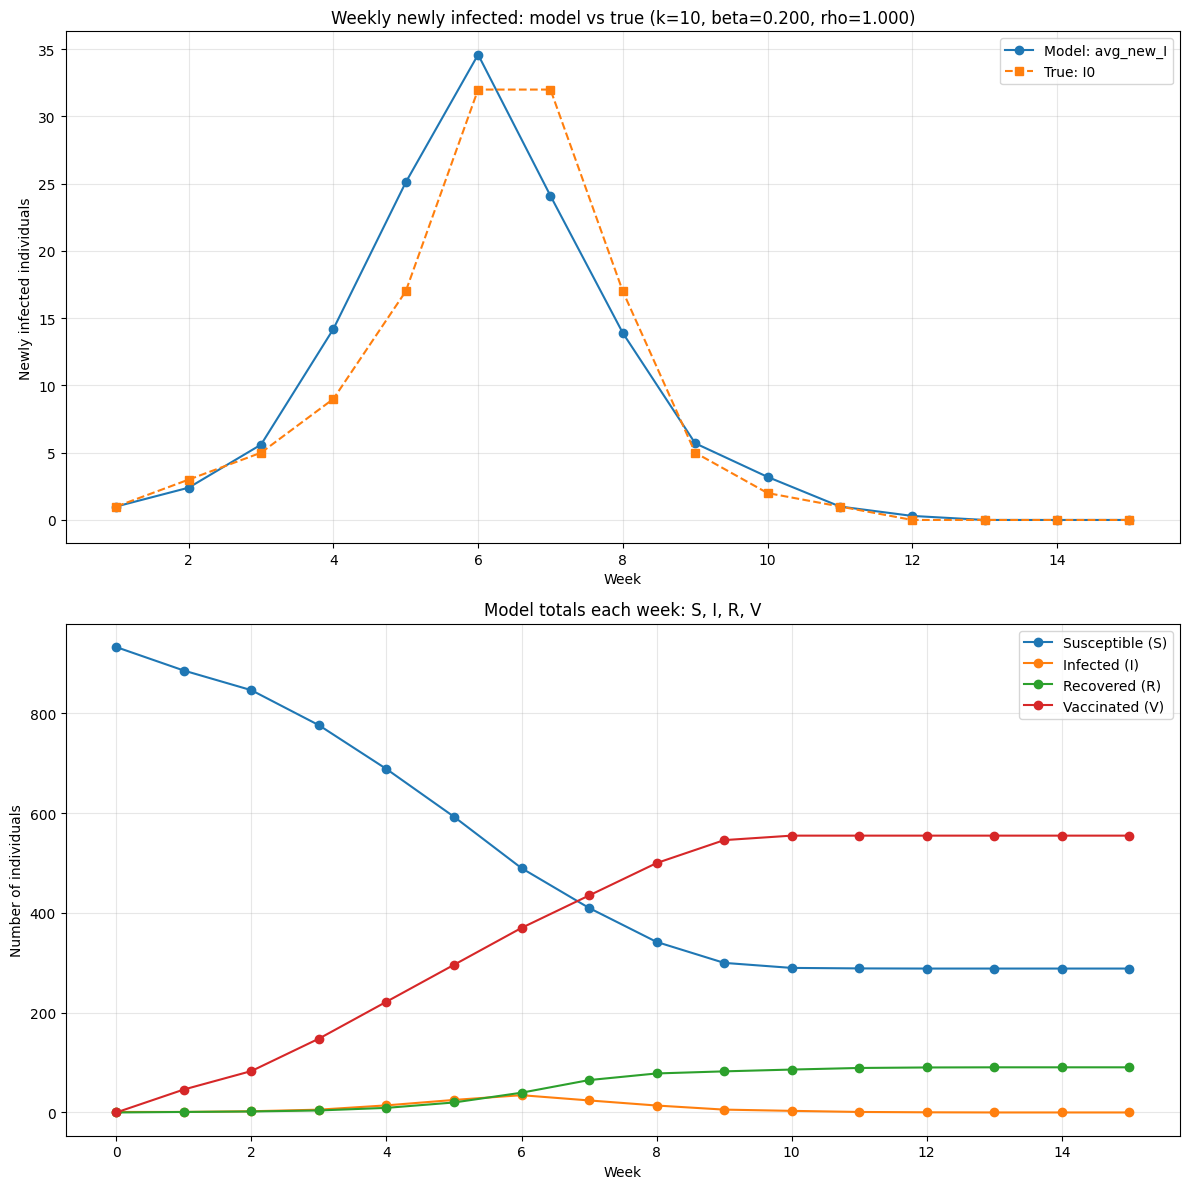

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1) Nuovi infetti settimanali: modello (avg_new_I) vs dati veri (I0)
plt.subplot(2, 1, 1)
plt.plot(range(1, WEEKS + 1), avg_new_I[1:], marker='o', linestyle='-', label='Model: avg_new_I')
plt.plot(range(1, WEEKS + 1), I0[1:],        marker='s', linestyle='--', label='True: I0')
plt.title(f'Weekly newly infected: model vs true (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f})')
plt.xlabel('Week')
plt.ylabel('Newly infected individuals')
plt.grid(True, alpha=0.3)
plt.legend()

# 2) Stati S, I, R, V nel tempo (modello)
plt.subplot(2, 1, 2)
plt.plot(range(0, WEEKS + 1), avg_S, marker='o', label='Susceptible (S)')
plt.plot(range(0, WEEKS + 1), avg_I, marker='o', label='Infected (I)')
plt.plot(range(0, WEEKS + 1), avg_R, marker='o', label='Recovered (R)')
plt.plot(range(0, WEEKS + 1), avg_V, marker='o', label='Vaccinated (V)')
plt.title('Model totals each week: S, I, R, V')
plt.xlabel('Week')
plt.ylabel('Number of individuals')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [64]:
import numpy as np

def fit_h1n1_refine_adaptive_steps(
    k0=10, beta0=0.3, rho0=0.6,
    dk=1, db=0.1, dr=0.1,
    min_dk=1, min_db=0.005, min_dr=0.005,
    shrink=0.5,
    max_iters=200,
    round_p=6
):
    """
    Adaptive local refinement for (k, beta, rho) using a discrete 3x3x3 neighborhood search.

    At each iteration we evaluate the cube centered at the current parameters:
        k in {k0-dk, k0, k0+dk}
        beta in {beta0-db, beta0, beta0+db}
        rho in {rho0-dr, rho0, rho0+dr}
    (with bounds: k>=2, beta/rho in [0,1]). We pick the best point in that cube and:
      - if it improves, we move the center there and repeat;
      - if the best point is the current center ("stuck"), we DO NOT stop immediately.
        Instead, we shrink exactly one step size among dk/db/dr (down to min_*),
        choosing the parameter direction that looks the flattest around the center
        (smallest RMSE increase to axis-only neighbors). This lets the search keep
        refining even when the coarse grid can’t find a better neighbor.

    A small cache is used to avoid re-running the simulator for identical (k,beta,rho)
    (after rounding/quantization), speeding things up without changing the logic.

    Returns:
        global_best tuple:
        (rmse, k, beta, rho, avg_new_I, avg_S, avg_I, avg_R, avg_V)
    """

    # Best overall solution found so far:
    # (rmse, k, beta, rho, avg_new_I, avg_S, avg_I, avg_R, avg_V)
    global_best = None

    # Cache evaluations to avoid recomputing the same (k,beta,rho) multiple times
    cache = {}

    def key_of(k, b, r):
        """Quantize parameters so float keys are stable in the cache."""
        return (int(k), round(float(b), round_p), round(float(r), round_p))

    def eval_point(k, b, r):
        """Evaluate (k,beta,rho) via the simulator, using cache when possible."""
        kk, bb, rr = key_of(k, b, r)
        if (kk, bb, rr) in cache:
            return cache[(kk, bb, rr)]
        rmse, avg_new_I, avg_S, avg_I, avg_R, avg_V = simulate_avg_I_and_states(kk, bb, rr)
        out = (rmse, kk, bb, rr, avg_new_I, avg_S, avg_I, avg_R, avg_V)
        cache[(kk, bb, rr)] = out
        return out

    # Current center (cast/round to keep the grid stable)
    k0 = int(k0)
    beta0 = round(float(beta0), round_p)
    rho0  = round(float(rho0), round_p)

    dk = int(dk)
    db = float(db)
    dr = float(dr)

    it = 0
    while it < max_iters:
        it += 1

        # 3x3x3 neighborhood around the current center
        k_space = [k0 - dk, k0, k0 + dk]
        b_space = [beta0 - db, beta0, beta0 + db]
        r_space = [rho0  - dr, rho0,  rho0  + dr]

        best_local = None
        rmse_at = {}  # store RMSEs to reuse for "axis-only" checks

        # Evaluate all valid points in the local cube
        for k in k_space:
            if k < 2:
                continue
            k = int(k)

            for beta in b_space:
                if beta < 0 or beta > 1:
                    continue
                beta = round(float(beta), round_p)

                for rho in r_space:
                    if rho < 0 or rho > 1:
                        continue
                    rho = round(float(rho), round_p)

                    cand = eval_point(k, beta, rho)
                    rmse_at[(cand[1], cand[2], cand[3])] = cand[0]

                    if (best_local is None) or (cand[0] < best_local[0]):
                        best_local = cand
                    if (global_best is None) or (cand[0] < global_best[0]):
                        global_best = cand

        rmse_best, k_best, beta_best, rho_best = best_local[0], best_local[1], best_local[2], best_local[3]
        print(
            f"best local RMSE={rmse_best:.4f} at (k={k_best}, beta={beta_best:.3f}, rho={rho_best:.3f}) "
            f"| deltas: dk={dk}, db={db:.4f}, dr={dr:.4f}"
        )

        # "Stuck" means the best point in the cube is exactly the current center
        stuck = (k_best == k0) and (beta_best == beta0) and (rho_best == rho0)

        if not stuck:
            # Move the center to the local best point and continue
            k0, beta0, rho0 = k_best, beta_best, rho_best
            continue

        # If stuck and we cannot refine further, stop
        if (dk <= min_dk) and (db <= min_db) and (dr <= min_dr):
            break
                
        # We are "stuck": the best point in the 3x3x3 neighborhood equals the current center (k0, beta0, rho0).
        # Instead of stopping immediately, we attempt a finer local search by shrinking ONE step size (dk, db, or dr).
        # To decide which step to shrink, we look at "axis-only" neighbors: move ±step along a single parameter while
        # keeping the other two fixed, and measure how much the RMSE increases compared to the center.
        # The flattest direction (smallest RMSE increase) is the best candidate to refine, so we shrink that step
        # (dk is halved as an integer; db/dr are multiplied by `shrink`), respecting the minimum step limits.
        # We keep the same center and repeat the loop with the smaller step, effectively zooming in around the same point.

        # RMSE at the center (already evaluated in the cube)
        rmse_center = rmse_at.get((k0, beta0, rho0), best_local[0])
        INF = 1e18

        # Check "axis-only" neighbors to decide which step to shrink:
        # shrink the axis that looks flattest (smallest RMSE increase from the center).
        rmse_k = INF
        if dk > min_dk:
            cands = []
            if k0 - dk >= 2:
                cands.append((k0 - dk, beta0, rho0))
            cands.append((k0 + dk, beta0, rho0))
            vals = [rmse_at.get(p, None) for p in cands]
            for i, p in enumerate(cands):
                if vals[i] is None:
                    vals[i] = eval_point(*p)[0]
                    rmse_at[p] = vals[i]
            rmse_k = min(vals)

        rmse_b = INF
        if db > min_db:
            cands = []
            if beta0 - db >= 0:
                cands.append((k0, round(beta0 - db, round_p), rho0))
            if beta0 + db <= 1:
                cands.append((k0, round(beta0 + db, round_p), rho0))
            if cands:
                vals = [rmse_at.get(p, None) for p in cands]
                for i, p in enumerate(cands):
                    if vals[i] is None:
                        vals[i] = eval_point(*p)[0]
                        rmse_at[p] = vals[i]
                rmse_b = min(vals)

        rmse_r = INF
        if dr > min_dr:
            cands = []
            if rho0 - dr >= 0:
                cands.append((k0, beta0, round(rho0 - dr, round_p)))
            if rho0 + dr <= 1:
                cands.append((k0, beta0, round(rho0 + dr, round_p)))
            if cands:
                vals = [rmse_at.get(p, None) for p in cands]
                for i, p in enumerate(cands):
                    if vals[i] is None:
                        vals[i] = eval_point(*p)[0]
                        rmse_at[p] = vals[i]
                rmse_r = min(vals)

        # Compute RMSE increases vs center and pick the smallest (flattest direction)
        incs = []
        if dk > min_dk and rmse_k < INF:
            incs.append(("k", rmse_k - rmse_center))
        if db > min_db and rmse_b < INF:
            incs.append(("beta", rmse_b - rmse_center))
        if dr > min_dr and rmse_r < INF:
            incs.append(("rho", rmse_r - rmse_center))

        if not incs:
            break

        param_to_shrink = min(incs, key=lambda x: x[1])[0]

        if param_to_shrink == "k":
            dk = max(min_dk, max(1, dk // 2))
            print(f"  stuck -> shrinking dk (new dk={dk})")
        elif param_to_shrink == "beta":
            db = max(min_db, db * shrink)
            print(f"  stuck -> shrinking db (new db={db:.6f})")
        else:
            dr = max(min_dr, dr * shrink)
            print(f"  stuck -> shrinking dr (new dr={dr:.6f})")

        # Keep the same center and repeat with smaller step(s)

    return global_best


In [65]:
best = fit_h1n1_refine_adaptive_steps(
    k0=10, beta0=0.3, rho0=0.6,
    dk=3, db=0.1, dr=0.1,
    min_dk=1, min_db=0.01, min_dr=0.01
)

rmse_best, k_best, beta_best, rho_best, avg_new_I, avg_S, avg_I, avg_R, avg_V = best
print("\n=== BEST PARAMETERS (global minimum found) ===")
print(f"k = {k_best}")
print(f"beta = {beta_best}")
print(f"rho = {rho_best}")
print(f"RMSE = {rmse_best:.4f}")


best local RMSE=6.6968 at (k=7, beta=0.200, rho=0.600) | deltas: dk=3, db=0.1000, dr=0.1000
best local RMSE=6.6968 at (k=7, beta=0.200, rho=0.600) | deltas: dk=3, db=0.1000, dr=0.1000
  stuck -> shrinking dr (new dr=0.050000)
best local RMSE=6.1207 at (k=7, beta=0.200, rho=0.650) | deltas: dk=3, db=0.1000, dr=0.0500
best local RMSE=6.1207 at (k=7, beta=0.200, rho=0.650) | deltas: dk=3, db=0.1000, dr=0.0500
  stuck -> shrinking dr (new dr=0.025000)
best local RMSE=6.1207 at (k=7, beta=0.200, rho=0.650) | deltas: dk=3, db=0.1000, dr=0.0250
  stuck -> shrinking db (new db=0.050000)
best local RMSE=4.9156 at (k=10, beta=0.150, rho=0.625) | deltas: dk=3, db=0.0500, dr=0.0250
best local RMSE=4.2714 at (k=13, beta=0.100, rho=0.600) | deltas: dk=3, db=0.0500, dr=0.0250
best local RMSE=4.2714 at (k=13, beta=0.100, rho=0.600) | deltas: dk=3, db=0.0500, dr=0.0250
  stuck -> shrinking dk (new dk=1)
best local RMSE=4.2714 at (k=13, beta=0.100, rho=0.600) | deltas: dk=1, db=0.0500, dr=0.0250
  stuck

## 2

In [66]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from scipy.linalg import null_space
from collections import Counter, defaultdict

In [67]:
N_PLAYERS = 3
ACTIONS = [1, -1]
N_ACTIONS = len(ACTIONS)
N_STEPS = 100
N_SIMULATIONS = 10000
BURN_IN = 10

n_states_tuple = tuple(N_ACTIONS for _ in range(N_PLAYERS))
n_config = N_ACTIONS ** N_PLAYERS
BETA = 6.0

In [68]:
def get_utility(player_idx, config_tuple, n1):
    u = 0
    is_coordinator = player_idx < n1
    
    for j in range(N_PLAYERS):
        if j == player_idx: continue
        
        if is_coordinator:
            val = 0.5 * abs(config_tuple[player_idx] + config_tuple[j])
        else:
            val = 0.5 * abs(config_tuple[player_idx] - config_tuple[j])
        u += val
    return u


def build_Lambda(n1):
    Lambda = sp.sparse.lil_matrix((n_config, n_config))

    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple) # Converts numeric index in a tuple of indices
        x_indices = np.array(x_indices)
        
        # Mapping indices -> real values
        current_config = [ACTIONS[k] for k in x_indices]
        
        for player in range(N_PLAYERS):
            utilities = []
            for action_idx, action_val in enumerate(ACTIONS):
                y_config = list(current_config)
                y_config[player] = action_val
                utilities.append(get_utility(player, y_config, n1))
            
            # Best Response Set
            max_u = max(utilities)
            br_indices = [idx for idx, u in enumerate(utilities) if u == max_u]
            
            # Compute choice probability
            prob_choice = 1.0 / len(br_indices)
            
            for action_idx in br_indices:
                if action_idx == x_indices[player]:
                    continue
                
                y_indices = np.copy(x_indices)
                y_indices[player] = action_idx
                y_id = np.ravel_multi_index(tuple(y_indices), dims=n_states_tuple)
                
                Lambda[x_id, y_id] += 1.0 * prob_choice

    return Lambda


# using the 2nd approach of CTMC
def simulation(Lambda, start_id, N_STEPS=100):    
    Lambda_dense = Lambda.toarray()
    n_states = Lambda_dense.shape[0]

    w = np.sum(Lambda_dense, axis=1)


    for i in range(n_states):
        if w[i] == 0: # absorbing state, no changes
            w[i] = 1.0
            Lambda_dense[i, i] = 1.0

    P = Lambda_dense / w[:, None]


    states = np.zeros(N_STEPS, dtype=int)
    transition_times = np.zeros(N_STEPS)
    
    states[0] = start_id
    current_id = start_id
    current_time = 0.0

    # simulation cycle
    for i in range(1, N_STEPS):
        t_next = -np.log(np.random.rand()) / w[current_id]
        
        current_time += t_next
        transition_times[i] = current_time

        probs = P[current_id, :]
        next_id = np.random.choice(n_states, p=probs)
        states[i] = next_id
        current_id = next_id

    return transition_times, states


# for a better visualization
def get_label(x_id):
        idx = np.unravel_index(x_id, n_states_tuple)
        return "".join(["+" if ACTIONS[k]==1 else "-" for k in idx])

In [69]:
def solver(n1, title_suffix):
    print(f"{title_suffix} (n1={n1})")

    start_indices = (0, 1, 0) # initial state (1, -1, 1)
    start_id = np.ravel_multi_index(start_indices, dims=n_states_tuple)

    Lambda = build_Lambda(n1)

    # transition graph
    G = nx.DiGraph()
    cx = Lambda.tocoo() # convert to Coordinate format for easy iteration
    for i, j, v in zip(cx.row, cx.col, cx.data):
        G.add_edge(get_label(i), get_label(j), weight=v)


    # Compute stationary distribution
    total_time_in_state = defaultdict(float)
    total_valid_time = 0.0
    for i in range(N_SIMULATIONS):
        times, traj = simulation(Lambda, start_id, N_STEPS)
        for k in range(len(traj) - 1):
            if k < BURN_IN: 
                continue # Skip the initial transition
                
            state = traj[k]
            duration = times[k+1] - times[k]
            
            total_time_in_state[state] += duration
            total_valid_time += duration

    results = {}
    for state_id, time_spent in total_time_in_state.items():
        if time_spent > 0:
            results[get_label(state_id)] = time_spent / total_valid_time

    sorted_labels = sorted(results.keys())
    sorted_probs = [results[lbl] for lbl in sorted_labels]
    
    print("\nResults:")
    for lbl, prob in zip(sorted_labels, sorted_probs):
        if prob > 1e-4:
            print(f"  State {lbl}: {prob:.4f}")


    # Simulation for plotting
    times, traj = simulation(Lambda, start_id, N_STEPS)
    

    # Plot simulation
    plt.figure(figsize=(10, 4))
    plt.step(times, traj, where='post', color='blue', marker='o', markersize=4, linewidth=1.5)
    plt.yticks(range(n_config), [get_label(i) for i in range(n_config)])
    plt.title(f"Traiettoria (Sparse Matrix)\n{title_suffix}")
    plt.xlabel("Time")
    plt.grid(True, alpha=0.3)
    plt.show()
    

    # Plot transition graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42, k=1.5)
    nx.draw_networkx(G, pos, node_color='lightgray', node_size=1500, edgecolors='black')
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=15, edge_color='gray')
    
    nx.draw_networkx_edge_labels(
        G, pos, 
        edge_labels=edge_labels, 
        font_size=8, 
        label_pos=0.6,
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
    )
    plt.axis('off')
    plt.title(f"Transition Graph\n{title_suffix}")
    plt.show()

Pure cooridination (n1=3)

Results:
  State +++: 0.6690
  State ---: 0.3310


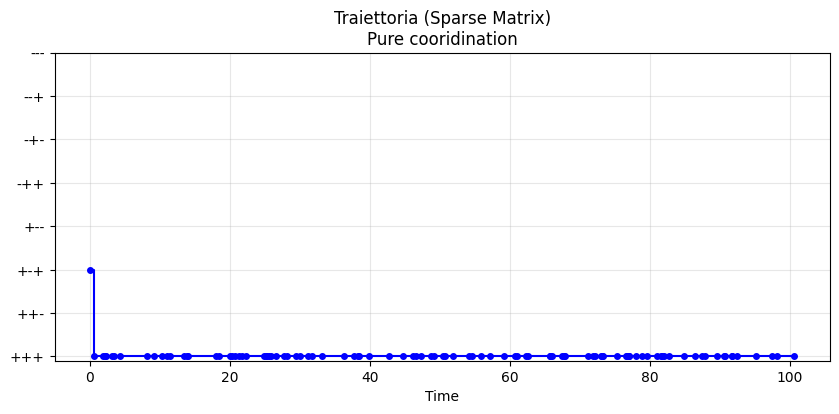

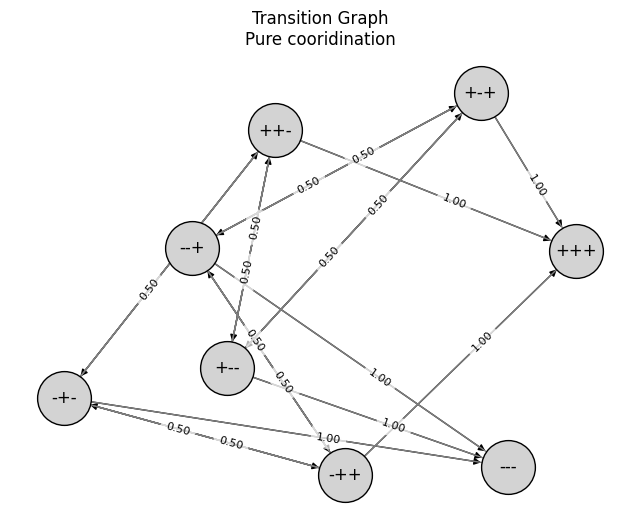

In [70]:
solver(3, "Pure cooridination")

Anti-Coordination (n1=0)

Results:
  State ++-: 0.1688
  State +-+: 0.1687
  State +--: 0.1648
  State -++: 0.1691
  State -+-: 0.1652
  State --+: 0.1633


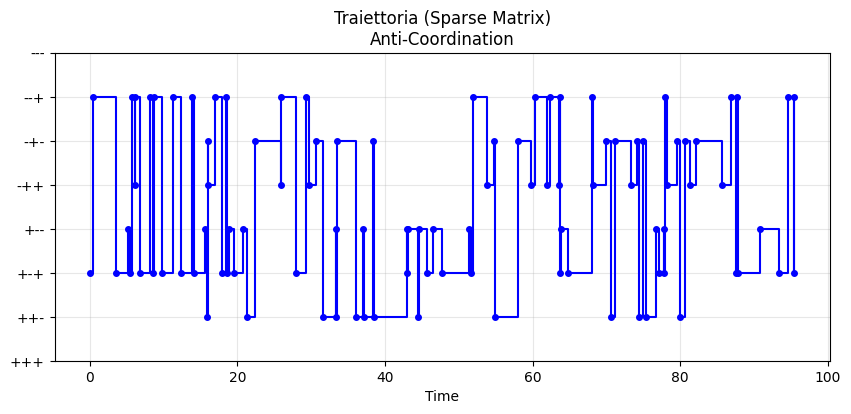

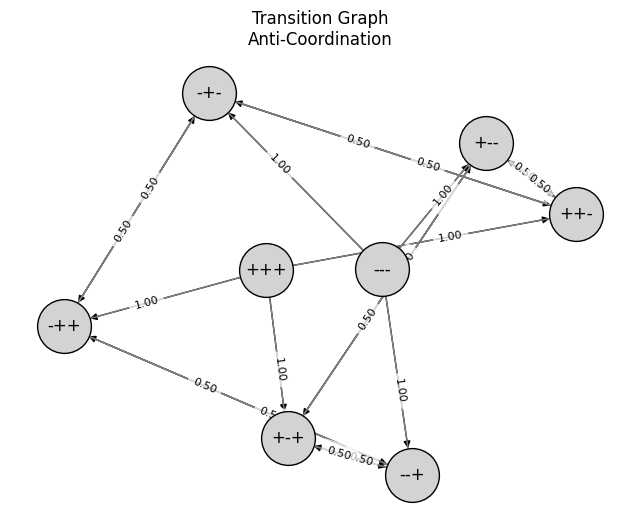

In [71]:
solver(0, "Anti-Coordination")

### Noisy Dynamics Best Response

with $\beta \rightarrow \infty$ (vanishing noise)

In [72]:
# List of all states
ALL_STATES = list(itertools.product(ACTIONS, repeat=N_PLAYERS))

def build_Lambda_noisy(n1, beta):
    Lambda = sp.sparse.lil_matrix((n_config, n_config))

    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple)
        x_indices = np.array(x_indices)
        
        current_config = [ACTIONS[i] for i in x_indices]
        
        for player in range(N_PLAYERS):
            utilities = np.zeros(N_ACTIONS)
            for action_idx, action_val in enumerate(ACTIONS):
                y_config = list(current_config)
                y_config[player] = action_val
                utilities[action_idx] = get_utility(player, y_config, n1)
            
            # exp(beta * U)
            exp_utilities = np.exp(beta * utilities)
            sum_exp = np.sum(exp_utilities)
            
            for action_idx, action_val in enumerate(ACTIONS):
                if action_idx == x_indices[player]:
                    continue

                y_indices = np.copy(x_indices)
                y_indices[player] = action_idx
                y_id = np.ravel_multi_index(tuple(y_indices), dims=n_states_tuple)
                
                Lambda[x_id, y_id] += exp_utilities[action_idx] / sum_exp

    return Lambda


def noisy_solver(n1, title_suffix):
    print(f"{title_suffix} (n1={n1})")

    start_indices = (0, 1, 0) # initial state (1, -1, 1)
    start_id = np.ravel_multi_index(start_indices, dims=n_states_tuple)
    
    Lambda = build_Lambda_noisy(n1, BETA)
    
    total_time_in_state = defaultdict(float)
    total_valid_time = 0.0
    for i in range(N_SIMULATIONS):
        times, traj = simulation(Lambda, start_id, N_STEPS)
        for k in range(len(traj) - 1):
            if k < BURN_IN: 
                continue
                
            state = traj[k]
            duration = times[k+1] - times[k]
            
            total_time_in_state[state] += duration
            total_valid_time += duration

    results = {}
    for state_id, time_spent in total_time_in_state.items():
        if time_spent > 0:
            results[get_label(state_id)] = time_spent / total_valid_time

    sorted_labels = sorted(results.keys())
    sorted_probs = [results[lbl] for lbl in sorted_labels]
    
    print("\nResults:")
    for lbl, prob in zip(sorted_labels, sorted_probs):
        if prob > 1e-4:
            print(f"State {lbl}: {prob:.4f}")
    

In [73]:
noisy_solver(3, "Pure Coordination")

Pure Coordination (n1=3)

Results:
State +++: 0.4933
State ---: 0.5066


In [74]:
noisy_solver(0, "Pure Anti-Coordination")

Pure Anti-Coordination (n1=0)

Results:
State ++-: 0.1683
State +-+: 0.1685
State +--: 0.1640
State -++: 0.1689
State -+-: 0.1651
State --+: 0.1652


with theory using:

$$
\lim_{\beta \to \infty} \lim_{t \to \infty} P(X(t) = x) = \lim_{\beta \to \infty} \pi_x = 
\begin{cases} 
\frac{1}{|\argmax \Phi|} & \text{if } x \in \argmax \Phi \\
0 & \text{otherwise} 
\end{cases}
$$

In [75]:
def get_potential_and_states(n1):
    states_data = []
    
    # all possible states
    for x_id in range(n_config):
        x_indices = np.unravel_index(x_id, shape=n_states_tuple)
        config = [ACTIONS[k] for k in x_indices]
        
        total_utility = sum(get_utility(i, config, n1) for i in range(N_PLAYERS))
        
        potential = 0.5 * total_utility # because each link is counted twice
        
        label = "".join(["+" if c==1 else "-" for c in config])
        states_data.append({'id': x_id, 'label': label, 'potential': potential})
        
    return states_data


def verify_theoretical_limit(n1):
    states_data = get_potential_and_states(n1)
    
    max_pot = max(s['potential'] for s in states_data)
    
    max_states = [s for s in states_data if np.isclose(s['potential'], max_pot)]
    
    prob_theoretical = 1.0 / len(max_states)
    
    print(f"Max potential: {max_pot}")
    print(f"State at max potential: {len(max_states)}")
    print(f"Theoretical probability: {prob_theoretical:.4f} on")
    for s in max_states:
        print(f"   * {s['label']}")

In [76]:
verify_theoretical_limit(3)

Max potential: 3.0
State at max potential: 2
Theoretical probability: 0.5000 on
   * +++
   * ---


In [77]:
verify_theoretical_limit(0)

Max potential: 2.0
State at max potential: 6
Theoretical probability: 0.1667 on
   * ++-
   * +-+
   * +--
   * -++
   * -+-
   * --+
